# CapgMyo Data

In [1]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import PIL
from PIL import Image
from sklearn.preprocessing import normalize
import matplotlib as mpl

In [2]:
mat_file = loadmat('./data/sample/capg-dba-001-001-001.mat')
emg_data = np.array(mat_file['data'])
print(mat_file.keys())
print(emg_data.max())
print(emg_data.min())
print(emg_data.mean())
emg_data.shape

dict_keys(['__header__', '__version__', '__globals__', 'trial', 'data', 'gesture', 'subject'])
1.2579447061003932
-1.2617399238461857
0.0005021637893446679


(1000, 128)

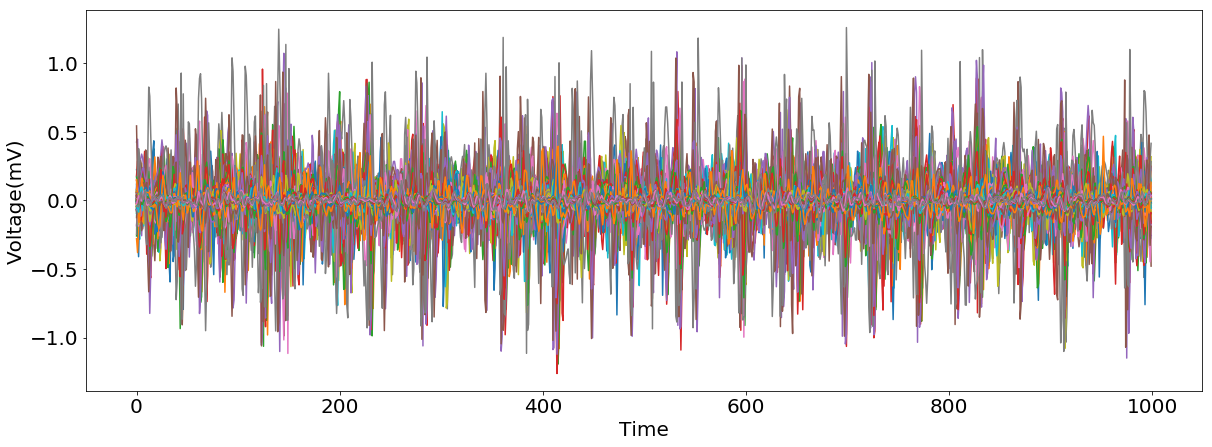

In [3]:
fig, ax = plt.subplots(figsize=(20,7))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.set_xlabel(xlabel='Time', fontsize=20)
ax.set_ylabel(ylabel='Voltage(mV)', fontsize=20)
for i in range(emg_data.shape[1]):
    plt.plot(emg_data[:,i])

In [4]:
emg_data = (emg_data + 1.5) / 3
# emg_data = np.absolute(emg_data)
# emg_data = emg_data * 255
print(emg_data.max())
print(emg_data.min())

0.9193149020334644
0.07942002538460476


In [9]:
def instant_image(idx, emg_sequence):
    frame = np.reshape(emg_sequence[idx], (8, 16))
    cm_hot = mpl.cm.get_cmap('seismic')
    im = cm_hot(frame)
    im = np.uint8(im * 255)
    im = Image.fromarray(im)

    resized_image = im.resize((300, 600), resample=PIL.Image.BICUBIC)
    plt.figure(figsize=(8, 16))
    plt.axis('off')
    plt.imshow(resized_image, cmap=mpl.cm.get_cmap('seismic'))

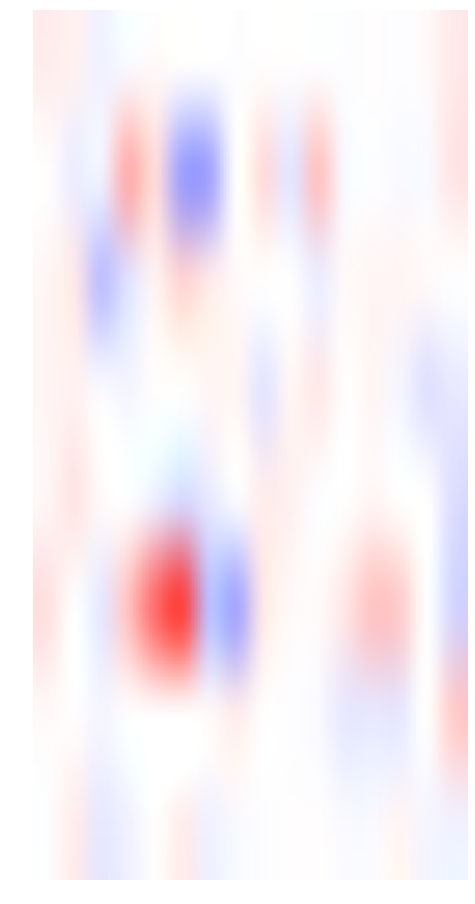

In [10]:
instant_image(0, emg_data)

### CSL-HDEMG Processing

In [1]:
import numpy as np
from scipy.io import loadmat
import os
import re
import h5py

import matplotlib.pyplot as plt
from math import sqrt

from scipy.ndimage.filters import median_filter
from scipy.signal import butter, lfilter

In [2]:
def butter_bandpass_filter(emg_data, lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq

    b, a = butter(order, [low, high], btype='bandpass')
    y = lfilter(b, a, emg_data)
    return y

In [3]:
def continuous_segments(label):
    label = np.asarray(label)

    if not len(label):
        return

    breaks = list(np.where(label[:-1] != label[1:])[0] + 1)
    for begin, end in zip([0] + breaks, breaks + [len(label)]):
        assert begin < end
        yield begin, end

In [4]:
def csl_cut(emg_data, framerate):
    window = int(np.round(150 * framerate / 2048))
    emg_data = emg_data[:len(emg_data) // window * window].reshape(-1, 150, emg_data.shape[1])
    rms = np.sqrt(np.mean(np.square(emg_data), axis=1))
    rms = [median_filter(image, 3).ravel() for image in rms.reshape(-1, 24, 7)]
    rms = np.mean(rms, axis=1)
    threshold = np.mean(rms)
    mask = rms > threshold
    for i in range(1, len(mask) - 1):
        if not mask[i] and mask[i - 1] and mask[i + 1]:
            mask[i] = True
    begin, end = max(continuous_segments(mask),
                     key=lambda s: (mask[s[0]], s[1] - s[0]))
    return begin * window, end * window

In [8]:
def csl_preprocess(path):
    mat = loadmat(path)
    trial = mat['gestures'][0, 0]
    trial = np.delete(trial,np.s_[7:192:8],0)
    trial = trial.T
    
    fig, ax = plt.subplots(figsize=(20,7))
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    ax.set_xlabel(xlabel='Time', fontsize=20)
    ax.set_ylabel(ylabel='Voltage', fontsize=20)
    for i in range(trial.shape[1]):
        plt.plot(trial[:,i])
        
    # bandpass
    trial = np.transpose([butter_bandpass_filter(ch, 20, 400, 2048, 4) for ch in trial.T])
    # cut
    begin, end = csl_cut(trial, 2048)
    print(begin, end)
    trial = trial[begin:end]
    # median filter
    trial = np.array([median_filter(image, 3).ravel() for image in trial.reshape(-1, 24, 7)])
    
    fig, ax = plt.subplots(figsize=(20,7))
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    ax.set_xlabel(xlabel='Time', fontsize=20)
    ax.set_ylabel(ylabel='Voltage', fontsize=20)
    for i in range(trial.shape[1]):
        plt.plot(trial[:,i])

1800 3150


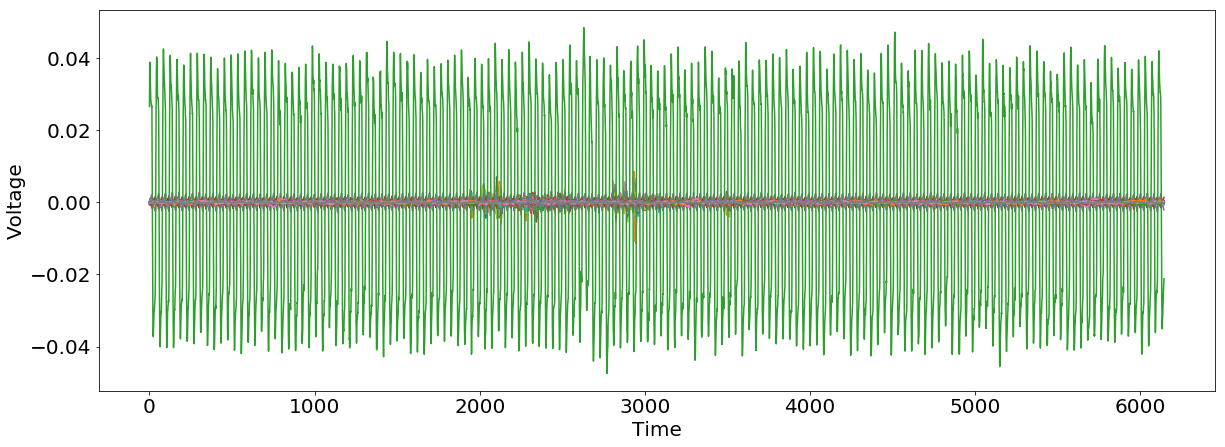

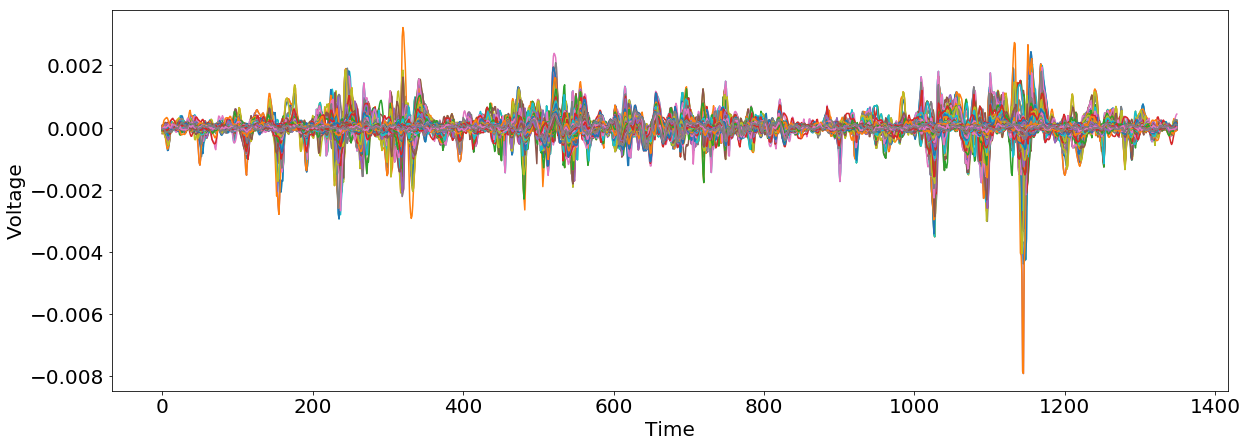

In [9]:
csl_preprocess('./data/sample/csl-539-gest9.mat')